# W14 PyTorch와 CNN으로 이미지 분류하기
### 이미지 분류 모델을 구축하고 성능 확인하기

* Dataset: CIFAR-10
> * 총 60,000장의 컬러(RGB) 이미지
> * 각 이미지는 가로 32 pixel, 세로 32pixel로 총 32 * 32 pixel로 구성
> * 10개의 서로다른 클래스(class)로 구성, 클래스당 6,000장
>  1. 비행기 (airplane)
>  2. 자동차 (automobile)
>  3. 새 (bird)
>  4. 고양이 (cat)
>  5. 사슴 (deer)
>  6. 개 (dog)
>  7. 개구리 (frog)
>  8. 말 (horse)
>  9. 배 (ship)
>  10. 트럭 (truck)

### CIFAR-10 데이터셋 예시
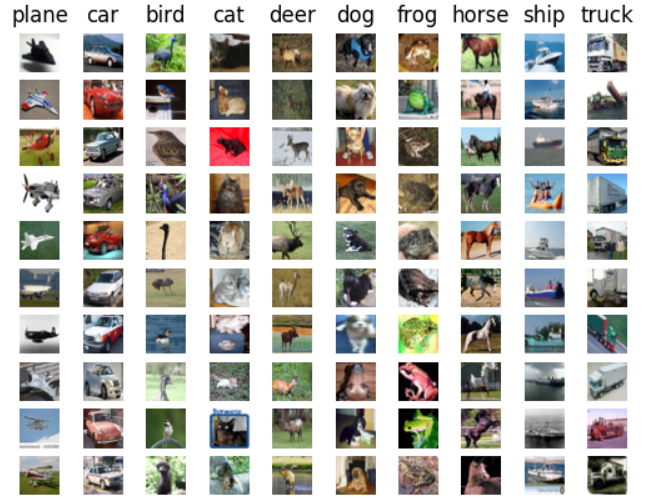

In [ ]:
# colab상에서 matplotlib라이브러리를 활용하여 출력할 결과들을 인라인으로 보기위해 실행
%matplotlib inline

## Import
* Dataset과 Dataloader?
파이토치(PyTorch)에는 데이터 작업을 위한 기본 요소 두가지인``torch.utils.data.DataLoader`` 와 ``torch.utils.data.Dataset`` 가 있다.
* ``Dataset`` 은 샘플과 정답(label)을 저장하고, ``DataLoader`` 는 ``Dataset`` 을 순회 가능한 객체로 만드는 역할을 한다.


In [ ]:
# 필요한 라이브러리 import
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

## Dataset 다운로드와 transform

* PyTorch는 다양한 라이브러리를 지원하며, 이번 실습에서 수행할 작업은 이미지분류에 해당 하므로 TorchVision을 사용
* ``torchvision.datasets`` 모듈은 CIFAR, COCO 등과 같은 다양한 컴퓨터비전 데이터를 지원
----

### 이번 실습에서는 "CIFAR-10" 데이터셋을 사용하였으며, 데이터셋을 다운로드하기위한 주요 파라미터는 아래와 같다.
- root: 최상위 폴더 위치(CIFAR-10은 data아래 위치)
- train: 학습용 데이터셋인지? (True (학습용) / False (테스트용) )
- download: 데이터셋을 인터넷을 통해 새로 다운로드 받을지(파이토치 datasets모듈에서 지원하는 데이터셋만 가능)
- transform: 데이터셋을 불러온 다음 어떻게 변형(transform)할지 (주로 파이토치에서 다루는 자료형인 tensor로 변경하거나, 이미지의 크기(해상도)등을 변경함)




In [ ]:
# transform 정의: tensor형태로 변환 -> RGB값들에 대해 정규화
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #3개 채널(R,G,B)에 대해 평균값 0.5, 표준편차 0.5 적용하여 -1 ~ 1 사이 값으로

# 공개 데이터셋에서 학습 데이터를 내려받기.
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# 공개 데이터셋에서 테스트 데이터를 내려받기.
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## DataLoader
* 다운로드 받은 ``Dataset`` 을 원활한 모델 훈련을 위해 ``DataLoader`` 의 인자로 전달
이를 통해 데이터셋을 순회 가능한 객체로 만들고, 자동화된 배치(batch), 샘플링(sampling),
섞기(shuffle) 및 다중 프로세스로 데이터 불러오기(multiprocess data loading)를 지원
* 실습에서는 배치 크기(batch size)를 64로 정의
* 이는 데이터로더(dataloader)에서 주는 객체의 각 요소는 64개의 특징(feature)과 정답(label) 묶음(batch)으로 구성하는것을 의미



In [ ]:
# 훈련에 사용할 배치사이즈 설정
batch_size = 64

# 데이터로더 생성
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# 데이터로더로 각 데이터의 형태 확인(총 수량, 채널 수, 높이, 너비)
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

## 모델 만들기
- PyTorch에서 신경망 모델은 [nn.Module]을
상속받는 클래스(class)를 생성하여 정의 가능
- ``__init__`` 함수에서 신경망의 계층(layer)들을 정의하고 ``forward`` 함수에서
신경망에 데이터를 어떻게 전달할지 구성들을 지정
- 가능한 경우 GPU에서 진행하면 연산을 가속할 수 있음
-----
**함수 및 메소드 간단 설명**
* torch.cuda.is_available() : 현재 상태에서 pyTorch가 gpu사용이 가능한지를 확인
> True: GPU 사용가능, False: GPU 인식불가(cpu로 진행하면 ok)
* nn.Linear(input,output): 선형연산이 이루어지는 신경망 층, input갯수만큼 들어가서 output갯수만큼 결과로 반환함
> Linear layer를 층별로 쌓을 때 앞층의 output과 다음층의 input크기가 같아야 함 주의
* flatten(): 데이터를 1 * N의 모양으로 변환(한줄로 세우기), input과 output수 동일
>  예시로 5 * 5 데이터를 flatten하면 1 * 25 형태가 됨
* nn.Relu(): 들어온 값에 대해 0이하는 0으로 출력, 0 이상은 본래 값을 그대로 출력하는 함수층




In [ ]:
# GPU 사용가능여부 확인 및 학습에 사용할 장치 지정
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

### 모델구조 참고 예시
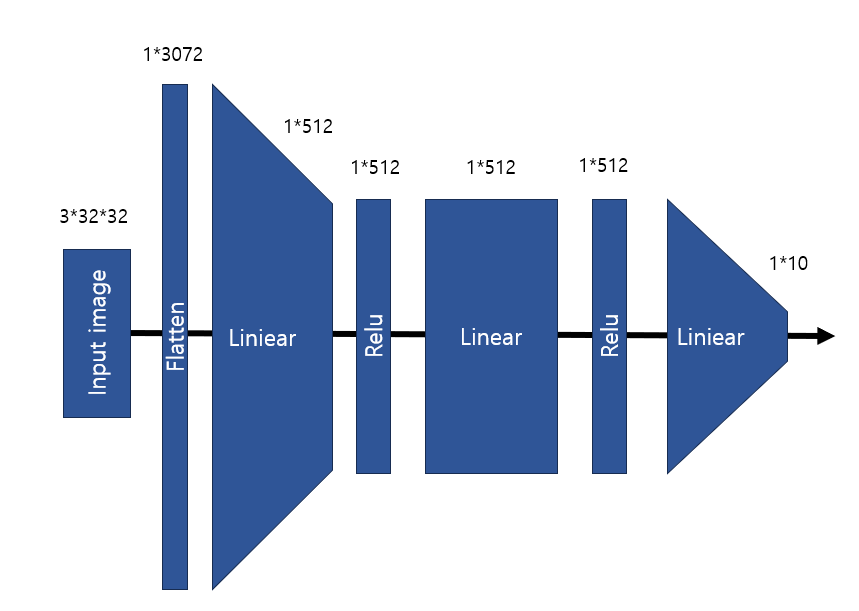

In [ ]:
# 모델 정의 클래스
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #전부 한줄로 펴기(flatten)
        self.flatten = nn.Flatten()
        #순차적(Sequential)으로 신경망을 통과하는 형태로 구성
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 512), #신경망 input: 3(채널)*32*32(너비및높이) , output: 512
            nn.ReLU(), #앞선 신경망에서 나온 결과값들에 대해 활성화 함수 사용, input과 output갯수 동일
            nn.Linear(512, 512), #신경망 input: 512 , output: 512
            nn.ReLU(), #앞선 신경망에서 나온 결과값들에 대해 활성화 함수 사용, input과 output갯수 동일
            nn.Linear(512, 10)  #신경망 input: 512 , output: 10 (결과로 출력할 것이 총 10개 클래스에 대한 값이기 때문)
        )

    def forward(self, x): #실제 연산시 구조 (forward pass 정의)
        #forward 매소드로 들어오는 첫 x값은 데이터(텐서형태 등으로 전처리된 이미지정보)

        #32*32 구조를 가지고 있는 이미지를 init에서 정의한 flaten으로 한줄로 펴기 1*1024
        x = self.flatten(x)
        #한줄로 펴진 이미지를 init에서 정의한 linear_relu_stack에 통과시켜 10개의 output획득
        logits = self.linear_relu_stack(x)
        return logits #10개 결과는 해당 클래스에 대한 확률에 해당


In [ ]:
# 모델 객체를 생성하고 연산을 수행할 장치( cpu 혹은 gpu) 지정
model = NeuralNetwork().to(device)
print(model) # 정의한 모델구조 출력

## 모델 매개변수 최적화하기
* 모델 구조가 지정되었지만 실제로 학습하려면 손실 함수(loss function)와
옵티마이저(optimizer) 가 필요
* 실습에서는 손실함수로 CrossEntropy라는 손실함수를 활용
> - 손실함수는 모델 학습과정에서 **실제 정답과 예측값의 오차를 계산**하는 역할을 하여 성능을 확인할 수 있고, 훈련과정에서 이러한 오차값을 줄이는 방향으로 학습을 유도하는 이정표 역할
* 옵티마이저로 SGD(Stochastic gradient descent, 확률적 경사하강)를 사용
> - 기울기를 계산하고 **오차를 줄이는 방향으로 가중치(weight)를 업데이트** 하며 이 과정에서 학습과정의 하이퍼파라미터중 하나인 **학습률(Learning-rate)을 조정**하는 역할  



In [ ]:
# 손실함수: 파이토치에서 제공하는 CrossEntropy가 구현된 객체를 만들어서 변수 loss_fn에 저장
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저: 파이토치에서 제공하는 SGD로 객체를 만들어서 변수 optimizer에 저장
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## 모델 학습 함수
* 각 학습 단계(training loop)에서 모델은 (배치(batch)로 제공되는) 학습 데이터셋에 대한 예측을 수행하고,
예측 오류를 역전파하여 모델의 레이어에 있는 가중치(weight)를 조정
* 역전파에서 optimizer.zero_grad()를 통해 열심히 계산한 기울기를 초기화 하는 이유?
> * 파이토치에서 연산 과정들은 자동 미분(Automatic Differentiation)기능이 있어 연산 기록들이 저장되어 자동으로 기울기값이 구해짐
> * 만약 학습과정에서 초기화를 사용하지 않는다면 기울기 값 계산시 이전 값까지 누적되므로 잘못된 방향으로 가중치가 업데이트 될 수 있으므로 주의


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # dataloader에서 feature정보인 X와 대응되는 정답값 y를 연산을 수행할 장치에 할당

        # 예측 오류 계산
        pred = model(X) # X에 할당된 데이터에 대해 예측
        loss = loss_fn(pred, y) # 손실함수로 실제값 y와 예측값간 오차 계산

        # 역전파
        optimizer.zero_grad() # 기울기 초기화
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

        # (option) 현재 학습상태 출력
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## 테스트 함수
* 모델이 잘 학습했는지 알기 위해 훈련 함수와 마찬가지로 테스트 함수 생성


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # 데이터 수 확인
    num_batches = len(dataloader) # 배치사이즈 확인

    # 학습이 아니라 평가 목적이므로 해당 모드로 변경
    model.eval()

    # 오차와 정답 수를 0으로 초기화, 지정
    test_loss, correct = 0, 0

    # 평가 (평가과정은 학습때처럼 기울기 계산 필요가 없으므로 no_grad()활용)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item() # 오차 합산
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # 맞춘 수 합산
    test_loss /= num_batches # test_loss에 저장된 오차를 배치수만큼 나누어 다시 test_loss에 저장
    correct /= size # correct에 저장된 수를 데이터 수만큼 나누어 다시 correct에 저장
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## 모델 학습
* 학습 단계는 여러번의 반복 단계 (*에폭(epochs)*) 를 거쳐서 수행
* 각 에폭에서 모델은 더 나은 예측을 하기 위해 가중치를  조정하여 학습
* 앞서 정의해둔 학습함수와 테스트 함수를 활용하여 각 에폭마다 모델의 정확도(accuracy)와 손실(loss)을 출력하고 epoch마다 정확도와 손실 변화 확인하기




In [ ]:
# epoch 설정
epochs = 10

# epoch수 만큼 학습을 위한 loop및 학습중 성능 확인을 위한 코드
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer) # 학습을 위해 만든 train 함수 사용
    test(test_dataloader, model, loss_fn) # 모델의 테스트를 위해 만든 test 함수 사용
print("Done!")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = [ 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

#이미지 결과 시각화를 위한 함수 정의
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    np_image = img.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))

    plt.imshow(np_image, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{classes[int(predicted_label)]}({classes[int(true_label)]})",
               color=color)

model.eval()

size = len(test_dataloader.dataset) # 데이터 수 확인
num_batches = len(test_dataloader)

test_loss, correct = 0, 0

# 테스트 데이터에 대한 예측 수행
predictions = []
X_test = []
y_test = []
with torch.no_grad():
    for images, label in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 각 이미지에 대한 예측된 클래스 얻기
        correct += (predicted.cpu() == label).type(torch.float).sum().item() # 맞춘 수 합산
        predictions.extend(predicted.cpu().numpy())
        X_test.extend(images.cpu())
        y_test.extend(label)

    correct /= size # correct에 저장된 수를 데이터 수만큼 나누어 다시 correct에 저장

print(f"Accuracy: {(100*correct):>0.1f}% ")

In [ ]:
# 맞춘것은 파란색, 틀린 예측은 빨간색으로 표시하여 시각화
num_rows = 1
num_cols = 10
num_images = num_rows * num_cols

plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(1,num_images+1):
    plt.subplot(num_rows, 2 * num_cols, i)
    plot_image(i, predictions[i], y_test, X_test)


plt.tight_layout()
plt.show()


## 모델 저장
* 학습한 모델은 학습한 가중치 정보들을 저장할 수 있음
* 파이토치로 구현한 모델의 경우 일반적으로 **"pth"** 형식으로 저장


In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

## 모델 불러오기
* 이전에 학습한 정보를 불러올 수 있음
* 모델을 불러오는 과정에는 모델 구조를 다시 만들고 상태 사전을 모델에 불러오는 과정이 포함



In [ ]:
# 30 epoch 학습된 모델 다운로드

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YDRSExOCsT242XEPuHu6tGTzLv3Pm6by' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1YDRSExOCsT242XEPuHu6tGTzLv3Pm6by" -O model_30epoch.pth && rm -rf ~/cookies.txt


In [ ]:
new_model = NeuralNetwork().to(device)
new_model.load_state_dict(torch.load("model_30epoch.pth"))

## 불러온 모델로 예측하기



In [ ]:
new_model.eval()

size = len(test_dataloader.dataset) # 데이터 수 확인
num_batches = len(test_dataloader)

test_loss, correct = 0, 0

# 테스트 데이터에 대한 예측 수행
predictions = []
X_test = []
y_test = []
with torch.no_grad():
    for images, label in test_dataloader:
        images = images.to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs, 1)  # 각 이미지에 대한 예측된 클래스 얻기
        correct += (predicted.cpu() == label).type(torch.float).sum().item() # 맞춘 수 합산
        predictions.extend(predicted.cpu().numpy())
        X_test.extend(images.cpu())
        y_test.extend(label)

    correct /= size # correct에 저장된 수를 데이터 수만큼 나누어 다시 correct에 저장

print(f"Accuracy: {(100*correct):>0.1f}% ")

In [ ]:
# 맞춘것은 파란색, 틀린 예측은 빨간색으로 표시하여 시각화
num_rows = 1
num_cols = 10
num_images = num_rows * num_cols

plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(1,num_images+1):
    plt.subplot(num_rows, 2 * num_cols, i)
    plot_image(i, predictions[i], y_test, X_test)


plt.tight_layout()
plt.show()
